In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [3]:
N_CONCEPTS = 2
N_STUDENTS = 10
N_ATTEMPTS = 3
N_QUESTIONS = 5

# Algorithm parameters
INIT = 3
MAX_ITER = 100

### ALS Tensor Factorization

In [25]:
def als_tensor_factorization(student_performance, n_concepts=2, init=3, max_iter=100):
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

    error_run = []
    error_total_run = []
    student_performance_pred_run = []
    
    # Several starts
    for run in range(init):
        error = []
        student_performance_pred_list = []
    #     q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)

        for attempt in range(N_ATTEMPTS):
            student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)

        # Phase 1: prediction
        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):

            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            q_matrix = q_matrix / row_sums
            
            
            # Update T: T = YQ'(QQ')^(-1) = YQ^(-1)
            # (QQ')^(-1)
            q_matrix_transpose_inv = np.linalg.pinv(np.dot(q_matrix, q_matrix.T))
            
            # YQ'
            YQ = np.zeros((n_students, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                YQ[:, :, attempt] = np.dot(student_performance[:, :, attempt], q_matrix.T)
                
            # T = YQ'(QQ')^(-1)
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = np.dot(YQ[:, :, attempt], q_matrix_transpose_inv)
                
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error.append(np.sqrt(np.sum(np.power(diff, 2))))
            
            student_performance_pred_iter = student_performance_pred.copy()
            student_performance_pred_list.append(student_performance_pred_iter)
        student_performance_pred_run.append(student_performance_pred_list)
        error_run.append(error)
        error_total_run.append(error[-1])
                
            
    return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run

In [26]:
for run in range(50):
    student_performance = generate_sample(noise)
    student_performance[student_performance > 0.5] = 1
    student_performance[student_performance < 0.5] = 0
    q_matrix = als_tensor_factorization(student_performance, n_concepts=2, init=3, max_iter=50)
    row_sums = q_matrix.sum(axis=0, keepdims=True)
    print(row_sums)
#     print(X)

[[0.58543776 0.67279455 0.67279455 0.64561084 0.8336423 ]]
[[0.84251784 0.66021096 1.17567053 0.65414206 0.93900949]]
[[0.78357543 0.81184836 0.80766993 0.81184836 0.83941291]]
[[0.66980563 0.66980563 0.61514976 0.67642634 0.6071293 ]]
[[0.74016358 0.74016358 0.75374345 0.74016358 0.75374345]]
[[0.4601472  0.57590317 0.57590317 0.71025061 0.61132091]]
[[0.80651603 0.88864907 0.80651603 0.88864907 0.88864907]]
[[0.61723735 0.71835617 0.71835617 0.71835617 0.57700709]]
[[0.71087886 0.88862715 0.71087886 0.70746038 0.70746038]]
[[0.56842574 0.56842574 0.47643974 0.64895311 0.51998945]]
[[0.65996133 0.65996133 0.55686638 0.70429671 0.55686638]]
[[0.3747665  0.43826424 0.53335403 0.50923123 0.43826424]]
[[0.5273482  0.45771781 0.63232432 0.44388233 0.80257103]]
[[0.75286462 0.76790699 0.76790699 0.84582139 0.98020756]]
[[0.68475227 0.68475227 0.58930654 0.60559517 0.58930654]]
[[0.75223673 0.58059019 0.75223673 0.53766882 0.70969643]]
[[0.61756325 0.96176382 0.67805682 0.81126997 0.55994511

### Simulation 1 - Student Performance is the exact multiplication of  Q Matrix and Student Knowledge

In [5]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=0)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=0)
    q_matrix = q_matrix / row_sums

    student_knowledge = np.zeros((N_STUDENTS, N_CONCEPTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_STUDENTS, N_CONCEPTS, DENSITY).todense()

    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
        
    if noise:
        noise = np.random.normal(0, noise, (N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
        student_performance = student_performance + noise
        
    return student_performance

In [6]:
student_performance = generate_sample()

In [7]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=1, max_iter=4)

In [8]:
error_run

array([[3.99132192e-02, 1.47108740e-14, 1.51478071e-14, 1.59328638e-14]])

### Simulation 2 - Student Performance is the multiplication of Q Matrix and Student Knowledge plus noise

In [9]:
student_performance = generate_sample(0.5)

In [10]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=50)

In [11]:
error_run

array([[4.28762926, 4.28232382, 4.278913  , 4.27662949, 4.27503454,
        4.27387484, 4.27300197, 4.27232667, 4.27179325, 4.27136545,
        4.27101855, 4.27073501, 4.27050189, 4.27030938, 4.27014987,
        4.27001735, 4.26990701, 4.26981497, 4.26973808, 4.26967374,
        4.26961986, 4.26957467, 4.26953675, 4.2695049 , 4.26947812,
        4.26945559, 4.26943663, 4.26942067, 4.26940722, 4.26939588,
        4.26938632, 4.26937826, 4.26937145, 4.26936571, 4.26936087,
        4.26935678, 4.26935332, 4.26935041, 4.26934794, 4.26934586,
        4.26934411, 4.26934262, 4.26934137, 4.26934031, 4.26933941,
        4.26933865, 4.26933801, 4.26933747, 4.26933702, 4.26933663],
       [4.36485323, 4.26647555, 4.26240973, 4.26119492, 4.26089667,
        4.26105314, 4.26231548, 4.26365721, 4.26484984, 4.26582978,
        4.26660365, 4.26720266, 4.2676623 , 4.26801439, 4.26828482,
        4.26849369, 4.26865618, 4.26878363, 4.26888442, 4.26896481,
        4.26902941, 4.26908171, 4.26912433, 4.2

### Simulation 3 - Student Performance contains only zeros and ones

In [12]:
student_performance = generate_sample(0.5)

In [13]:
student_performance[student_performance > 0.5] = 1
student_performance[student_performance < 0.5] = 0

In [14]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=100)

In [15]:
best_run = np.unravel_index(error_run.argmin(), error_run.shape)
best_student_performance_pred = student_performance_pred_run[best_run]

In [16]:
best_student_performance_pred[best_student_performance_pred > 0.5] = 1
best_student_performance_pred[best_student_performance_pred < 0.5] = 0

In [17]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance, best_student_performance_pred)).sum())/(
    student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 82.67%


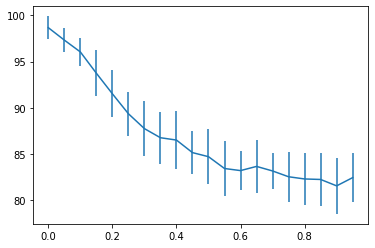

CPU times: user 1min 26s, sys: 59 ms, total: 1min 26s
Wall time: 1min 28s


In [19]:
%%time
accs = []
accs_std = []

for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0
        

#         Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)
        

#         Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0
        

#         Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)

    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

In [20]:
%%time
accs = []
accs_std = []
for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance, student_performance_t = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0

        # Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)

        # Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0

        # Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)
    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

ValueError: too many values to unpack (expected 2)

In [485]:
diff = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
for attempt in range(N_ATTEMPTS):
    diff[:, :, attempt] = student_performance[:, :, attempt] - best_student_performance_pred[:, :, attempt]

In [486]:
np.sqrt(np.sum(np.power(diff, 2)))

4.898979485566356